## Homework 4
### Due - 05/29/2020 - 11:59p - 20 points

**Name:** `<Patrick Brennan>`

**Email** `<Pbrennan@scu.edu>`

**Objectives:** The aim of this homework is to warm you up with `logistic regression` concept. You have to implement univariate linear regression by using `scikit-learn`.

**Problem Statement:** Across the nation, judges, probation and parole officers are increasingly using algorithms to assess a criminal defendant’s likelihood of becoming a recidivist – a term used to describe criminals who re-offend. There are dozens of these risk assessment algorithms in use. Many states have built their own assessments, and several academics have written tools. There are also two leading nationwide tools offered by commercial vendors.

We set out to assess one of the commercial tools made by Northpointe, Inc. to discover the underlying accuracy of their recidivism algorithm and to test whether the algorithm was biased against certain groups. 


**Submission Instructions:** 
* Please download `HW4.ipynb` and `compas-scores-two-years-violent.csv` files and insert cells in the `HW.ipynb` to complete your homework and submit the same file to Camino under `Homework` $\rightarrow$ `hw4`. Please feel free to use the `w8-LogisticRegression.ipynb` and `w8-MachineBias_all.ipynb` as references to work on this homework.

**Honor Code:** You are expected to complete the homework on your own. Solutions might exist elsewhere, but you are not allowed to copy them. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn import metrics
%matplotlib inline
figsize = (16,8)

In [ ]:
fname ='compas-scores-two-years-violent.csv'

# it's upto you whether you would use the following variables or not
decile_col = 'decile_score'
score_col = 'score_text'

In [ ]:
# read the file in dataframe
from google.colab import files
files.upload()
cv = pd.read_csv('compas-scores-two-years-violent.csv')
#cv = pd.read_csv(fname)

Saving compas-scores-two-years-violent.csv to compas-scores-two-years-violent (1).csv


In [ ]:
cv.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-11-30,Risk of Violence,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0


In [ ]:
# list the features of your dataset (aka columns)
cv.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid', 'two_year_recid.1'],
      dtype='object')

Following ProPublica, we filter out certain rows which are missing data. As they put it:

- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
- We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
- In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed
- We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [ ]:
# Data filtering is implemented for you
cv = cv[
    (cv.days_b_screening_arrest <= 30) &  
    (cv.days_b_screening_arrest >= -30) &  
    (cv.is_recid != -1) &
    (cv.c_charge_degree != 'O') &
    (cv[score_col] != 'N/A')
]

cv.reset_index(inplace=True, drop=True) # renumber the rows from 0 again


#### Question 1 (10 points): Exploring the data

In [ ]:
# Print the nature of crime each individual has committed
cv.c_charge_desc

0         Aggravated Assault w/Firearm
1       Felony Battery w/Prior Convict
2               Possession of Cannabis
3                arrest case no charge
4                              Battery
                     ...              
4738             Possession of Cocaine
4739                  Deliver Cannabis
4740     Leaving the Scene of Accident
4741     Aggravated Battery / Pregnant
4742     Battery on Law Enforc Officer
Name: c_charge_desc, Length: 4743, dtype: object

In [ ]:
# How many violent crimes have been committed?
cv.is_violent_recid.value_counts()

0    3924
1     819
Name: is_violent_recid, dtype: int64

In [ ]:
# which is the most prevalent age group for violent crimes?
violent_crimes_age = cv.groupby('is_violent_recid')['age'].apply(lambda x: x.value_counts().index[0]).reset_index()
print(violent_crimes_age)

   is_violent_recid  age
0                 0   24
1                 1   21


In [ ]:
# How many women are involved in violent crimes.
violent_crimes_sex = cv.groupby('sex')['is_violent_recid'].count()
print(violent_crimes_sex)

sex
Female     997
Male      3746
Name: is_violent_recid, dtype: int64


In [ ]:
# Print the decile scores for each race
decile_avg = cv.groupby('race')['decile_score'].mean()
print (decile_avg)


race
African-American    4.859223
Asian               2.592593
Caucasian           3.241623
Hispanic            3.159389
Native American     5.181818
Other               2.746429
Name: decile_score, dtype: float64


In [ ]:
# Show recidivism by race (make sure you consider all races)
recid_by_race = cv.groupby('race')['is_recid'].mean()
print (recid_by_race)

race
African-American    0.267432
Asian               0.222222
Caucasian           0.157554
Hispanic            0.144105
Native American     0.363636
Other               0.160714
Name: is_recid, dtype: float64


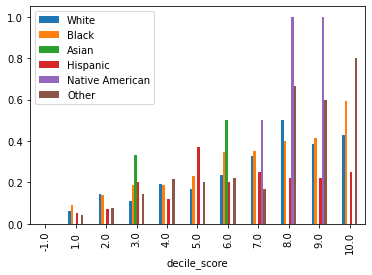

In [ ]:
# Plot a bar chart which has probability of recidivism by decile and race( every race)
b = cv[cv.race == 'African-American'].groupby([decile_col]).mean()['is_recid']
w = cv[cv.race == 'Caucasian'].groupby([decile_col]).mean()['is_recid']
a = cv[cv.race == 'Asian'].groupby([decile_col]).mean()['is_recid']
h = cv[cv.race == 'Hispanic'].groupby([decile_col]).mean()['is_recid']
na = cv[cv.race == 'Native American'].groupby([decile_col]).mean()['is_recid']
o = cv[cv.race == 'Other'].groupby([decile_col]).mean()['is_recid']

a = pd.concat([w,b,a,h,na,o], axis = 1)
a.columns = ['White','Black','Asian','Hispanic','Native American','Other']
a.plot.bar()


In [ ]:
cv.score_text.value_counts()

Low       1713
Medium     612
High       403
Name: score_text, dtype: int64

In [ ]:
# Create COMPAS recidivism confusion matrix
# Explain your observation
cv['guessed_recid'] = cv[score_col] != 'Low'
cv['actual_recid'] = cv.is_recid == 1
cm = pd.crosstab(cv.actual_recid, cv.guessed_recid)
cm

guessed_recid,False,True
actual_recid,,
False,1511,663
True,202,355


Use logistic regression to try to build our own predictor, just from the information we have.

`Age`
`Sex`
`Felony or Misdemeanor charge (c_charge_degree)`
`Number of prior arrests (c_priors_count)`

Now you will try building your predictor **both with and without race** and illustrate the difference in results.

#### Question 2 (5 points): Logistic Regression using race as an additional feature

In [ ]:
# Logistic Regression using race
# you can use the same x for training and testing
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
feature_cols = ['is_recid']

X = cv[feature_cols]

y = cv.race

logreg.fit(X,y)
cv['recid_race_pred_class'] = logreg.predict(X)
cv.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1,recid_race_pred_class
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0,African-American
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1,African-American
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,0,African-American
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0,African-American
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-11-30,Risk of Violence,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0,African-American


In [ ]:
def print_ppv_fpv(cm):
    TN = cm[False][False]   
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]
    print('Accuracy: ', (TN+TP)/(TN+TP+FN+FP))
    print('PPV: ', TP / (TP + FP))
    print('FPR: ', FP / (FP + TN))
    print('FNR: ', FN / (FN + TP))
    print()

def print_metrics(guessed, actual):
    cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
    print(cm)
    print()
    print_ppv_fpv(cm)    

In [ ]:
# show the confusion matrix using race
# compute accuracy, precision, FPR, FNR
print('White')
subset = cv[cv.race == 'Caucasian']
print_metrics(subset.guessed_recid, subset.actual_recid)

print('Black')
subset = cv[cv.race == 'African-American']
print_metrics(subset.guessed_recid, subset.actual_recid)

print('Asian')
subset = cv[cv.race == 'Asian']
print_metrics(subset.guessed_recid, subset.actual_recid)

print('Hispanic')
subset = cv[cv.race == 'Hispanic']
print_metrics(subset.guessed_recid, subset.actual_recid)

print('Native American')
subset = cv[cv.race == 'Native American']
print_metrics(subset.guessed_recid, subset.actual_recid)

print('Other')
subset = cv[cv.race == 'Other']
print_metrics(subset.guessed_recid, subset.actual_recid)

White
actual   False  True 
guessed              
False      658     81
True       180     71

Accuracy:  0.7363636363636363
PPV:  0.28286852589641437
FPR:  0.21479713603818615
FNR:  0.5328947368421053

Black
actual   False  True 
guessed              
False      549     93
True       407    248

Accuracy:  0.6144949884348496
PPV:  0.3786259541984733
FPR:  0.42573221757322177
FNR:  0.2727272727272727

Asian
actual   False  True 
guessed              
False        9      1
True         1      1

Accuracy:  0.8333333333333334
PPV:  0.5
FPR:  0.1
FNR:  0.5

Hispanic
actual   False  True 
guessed              
False      173     17
True        49     18

Accuracy:  0.7431906614785992
PPV:  0.26865671641791045
FPR:  0.22072072072072071
FNR:  0.4857142857142857

Native American
actual   False  True 
guessed              
False        5      0
True         1      3

Accuracy:  0.8888888888888888
PPV:  0.75
FPR:  0.16666666666666666
FNR:  0.0

Other
actual   False  True 
guessed              
